In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split



In [2]:
# Load data
data = pd.read_excel("D:/AAU/Module_4/Project_mo_4/pune_tomato_market.xlsx")
tomato = data[['Date', 'Price']]
tomato.set_index('Date', inplace=True)

In [3]:
# Prepare data
window_size = 5  # Number of previous days to use as features

# Create lagged features
def create_lagged_features(df, target_col, window_size):
    lagged_data = pd.DataFrame()
    for i in range(1, window_size + 1):
        lagged_data[f'lag_{i}'] = df[target_col].shift(i)
    lagged_data['target'] = df[target_col]
    lagged_data.dropna(inplace=True)
    return lagged_data

lagged_data = create_lagged_features(tomato, 'Price', window_size)



In [4]:
# Train-test split
X = lagged_data.drop(columns=['target'])
y = lagged_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [5]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [ ]:
# Forecast on the test set
y_pred = rf_model.predict(X_test)


In [19]:
# # Evaluation
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)


from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Calculate range and mean of actual values
range_y_test = np.max(y_test) - np.min(y_test)
mean_y_test = np.mean(y_test)

# Calculate RMSE and MAE as percentages of the range
rmse_percentage = (rmse / range_y_test) * 100
mae_percentage = (mae / range_y_test) * 100

# Calculate NRMSE and NRMAE (normalized by mean and range)
nrmse_by_mean = rmse / mean_y_test

# Print results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print(f"RMSE as a percentage of the range: {rmse_percentage:.2f}%")
print(f"MAE as a percentage of the range: {mae_percentage:.2f}%")
print(f"Normalized RMSE (NRMSE) by mean: {nrmse_by_mean:.2f}")


Mean Squared Error (MSE): 160475.85182968923
Root Mean Squared Error (RMSE): 400.59437318775366
Mean Absolute Error (MAE): 199.69153639634555
RMSE as a percentage of the range: 4.92%
MAE as a percentage of the range: 2.45%
Normalized RMSE (NRMSE) by mean: 0.27


In [ ]:
# Combine Actual and Predicted for Visualization
results = pd.DataFrame({
    'Actual_Price': y_train.values,
    'Predicted_Price': y_pred
}, index=X_test.index)

print(results.head())



            Actual_Price  Predicted_Price
Date                                     
2020-12-30        1200.0      1196.625000
2020-12-31        1000.0      1021.519048
2021-01-01         850.0      1124.850000
2021-01-02        1070.0      1050.419841
2021-01-03         650.0      1302.327778


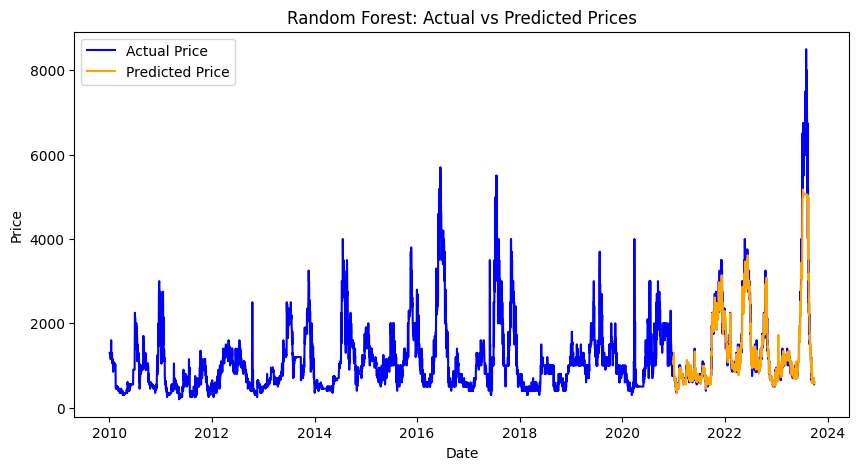

In [9]:
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tomato['Price'], label='Actual Price', color='blue')
plt.plot(results['Predicted_Price'], label='Predicted Price', color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('Random Forest: Actual vs Predicted Prices')
plt.legend()
plt.show()


In [10]:
# Forecast beyond the test set
def forecast_with_rf(model, last_known_values, forecast_periods, window_size):
    forecast = []
    current_input = last_known_values[-window_size:]  # Start with the last `window_size` values

    for _ in range(forecast_periods):
        # Predict the next value
        next_pred = model.predict(current_input.reshape(1, -1))[0]
        forecast.append(next_pred)

        # Update the input for the next prediction
        current_input = np.append(current_input[1:], next_pred)

    return forecast



In [21]:
# Forecast future periods
forecast_periods = 100
last_known_values = X_test.iloc[-1].values  # Last row of the test features
forecast_values = forecast_with_rf(rf_model, last_known_values, forecast_periods, window_size)

# Create a DataFrame for forecast
forecast_index = pd.date_range(start=tomato.index[-1], periods=forecast_periods + 1, freq='D')[1:]
forecast_df = pd.DataFrame({'Forecasted_Price': forecast_values}, index=forecast_index)

# Combine Actual, Predicted, and Forecasted for Visualization
all_results = pd.concat([
    tomato.loc[:y_test.index[-1]],
    forecast_df
], axis=0)




c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature 

In [25]:
# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Align predictions with the actual dataset index
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

# Use the original dataset index for proper plotting
train_index = X_train.index
test_index = X_test.index

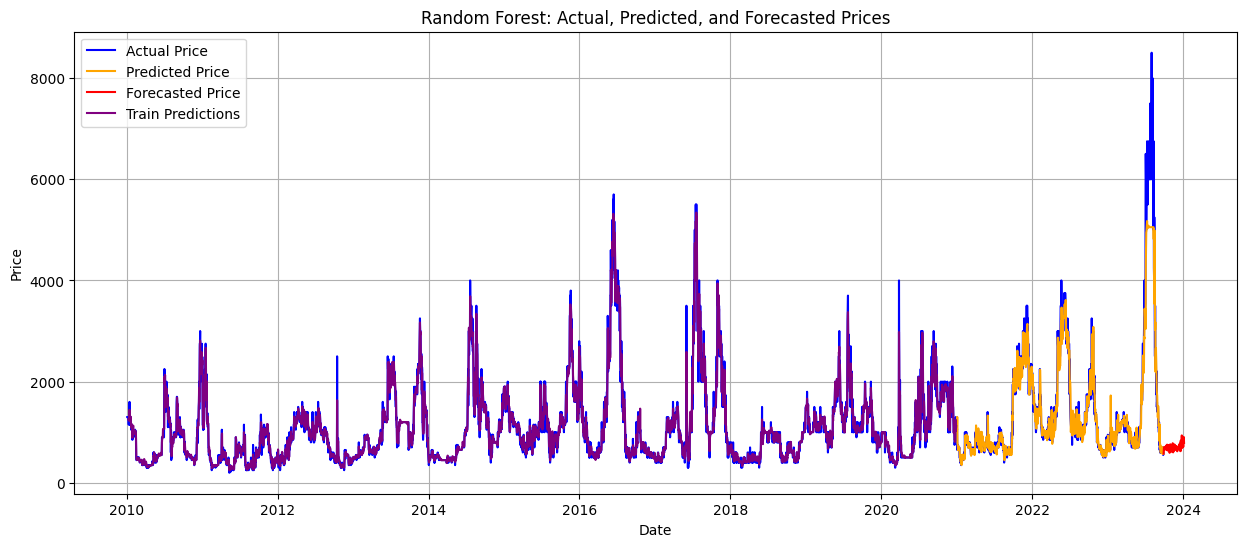

In [28]:
# Plot all results
plt.figure(figsize=(15, 6))
plt.plot(tomato['Price'], label='Actual Price', color='blue')
plt.plot(results.index, results['Predicted_Price'], label='Predicted Price', color='orange')
plt.plot(forecast_df.index, forecast_df['Forecasted_Price'], label='Forecasted Price', color='red')
plt.plot(train_index, train_predictions, label='Train Predictions', color='purple')
plt.title('Random Forest: Actual, Predicted, and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

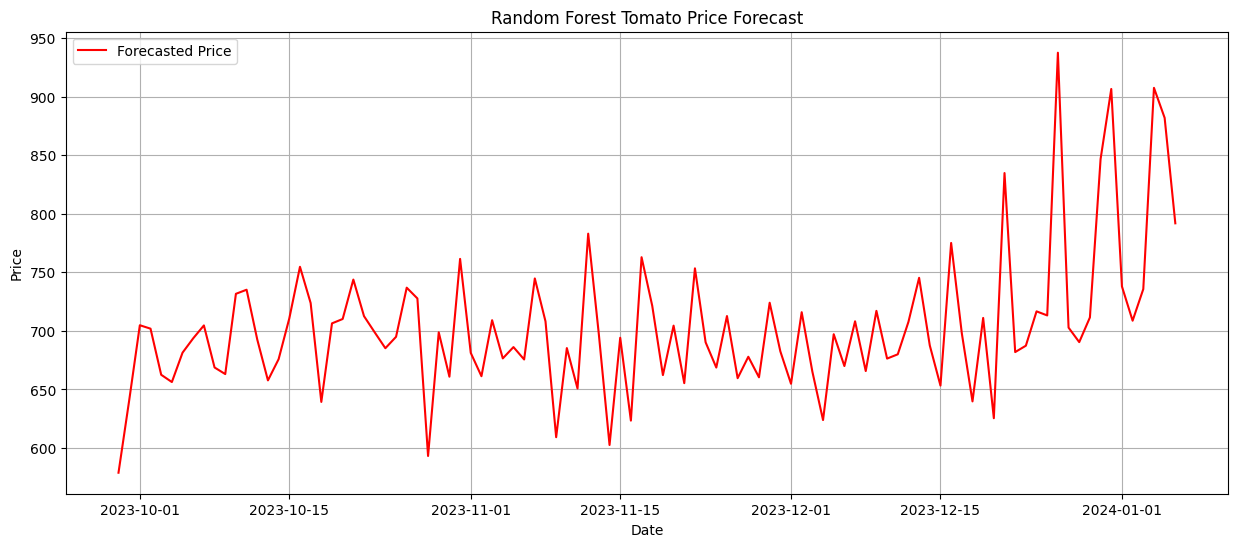

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(forecast_df.index, forecast_df['Forecasted_Price'], label='Forecasted Price', color='red')
plt.title('Random Forest Tomato Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()